In [3]:
!pip install scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 36.3 MB/s  0:00:00m0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 39.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 48.9 MB/s  0:00:00m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [scikit-learn] [scikit-learn]


In [1]:
import torch 
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, log_loss, ConfusionMatrixDisplay
import matplotlib.pyplot as plt 
import pandas as pd 

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

ModuleNotFoundError: No module named 'sklearn'

In [7]:
H_train = np.load('../data/processed_data/H_train_data.npy')
MDD_train = np.load('../data/processed_data/MDD_train_data.npy')
H_test = np.load('../data/processed_data/H_test_data.npy')
MDD_test = np.load('../data/processed_data/MDD_test_data.npy')

# remove diagonal elements
H_train = np.array([h-np.eye(h.shape[0], dtype=float) for h in H_train])
H_test = np.array([h-np.eye(h.shape[0], dtype=float) for h in H_test])
MDD_train = np.array([mdd-np.eye(mdd.shape[0], dtype=float) for mdd in MDD_train])
MDD_test = np.array([mdd-np.eye(mdd.shape[0], dtype=float) for mdd in MDD_test])


X_train = np.array([x.ravel() for x in np.vstack((H_train, MDD_train))])
X_test = np.array([x.ravel() for x in np.vstack((H_test, MDD_test))])
y_train = np.hstack((np.zeros(len(H_train)), np.ones(len(MDD_train))))
y_test = np.hstack((np.zeros(len(H_test)), np.ones(len(MDD_test))))



In [ ]:
## NOT splitting train-test by subject ==> leakage
# H_raw = np.array(np.load('../data/processed_data/H_data.npy'))
# MDD_raw = np.array(np.load('../data/processed_data/MDD_data.npy'))

# X = np.array([x.ravel() for x in np.vstack((H_raw, MDD_raw))])
# y = np.hstack((np.zeros(len(H_raw)), np.ones(len(MDD_raw))))


# X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8)

In [69]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class FlexibleMLP(nn.Module):
    def __init__(
        self,
        layer_sizes,
        hidden_activation="relu",
        last_hidden_activation=None,
        output_activation="sigmoid",
        dropout=0.0,
        batch_norm=False
    ):
        super().__init__()

        activation_map = {
            "relu": nn.ReLU(),
            "tanh": nn.Tanh(),
            "sigmoid": nn.Sigmoid(),
            "swish": nn.SiLU(),
            "leakyrelu": nn.LeakyReLU(),
            "none": nn.Identity()
        }

        layers = []
        num_layers = len(layer_sizes) - 1

        if isinstance(dropout, float):
            dropout = [dropout] * num_layers

        for i in range(num_layers):
            in_dim = layer_sizes[i]
            out_dim = layer_sizes[i+1]

            # Linear layer
            layers.append(nn.Linear(in_dim, out_dim))

            # Select activation
            if i < num_layers - 2:
                act = activation_map[hidden_activation.lower()]
            elif i == num_layers - 2:
                act = activation_map[last_hidden_activation.lower()] \
                      if last_hidden_activation else activation_map[hidden_activation.lower()]
            else:
                act = activation_map[output_activation.lower()]

            # Batch norm for hidden layers only
            if batch_norm and i < num_layers - 1:
                layers.append(nn.BatchNorm1d(out_dim))

            layers.append(act)

            # Dropout for hidden layers only
            if i < num_layers - 1 and dropout[i] > 0:
                layers.append(nn.Dropout(dropout[i]))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


class MLPClassifier:
    def __init__(
        self,
        layer_sizes,
        hidden_activation="relu",
        last_hidden_activation=None,
        output_activation="sigmoid",
        dropout=0.0,
        batch_norm=False,
        lr=1e-3,
        batch_size=32,
        max_epochs=200,
        patience=15
    ):
        self.net = FlexibleMLP(
            layer_sizes=layer_sizes,
            hidden_activation=hidden_activation,
            last_hidden_activation=last_hidden_activation,
            output_activation=output_activation,
            dropout=dropout,
            batch_norm=batch_norm
        )
        self.lr = lr
        self.batch_size = batch_size
        self.max_epochs = max_epochs
        self.patience = patience
        self.loss_curve_ = []
        self.accuracy_curve_ = []

        self.loss_fn = nn.BCELoss() 

    def fit(self, X, y):
        X = torch.tensor(X, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)

        optimizer = optim.Adam(self.net.parameters(), lr=self.lr)

        best_loss = np.inf
        patience_counter = 0
        dataset = torch.utils.data.TensorDataset(X, y)
        loader = torch.utils.data.DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        for epoch in range(self.max_epochs):
            self.net.train()
            running_loss = 0

            for xb, yb in loader:
                optimizer.zero_grad()
                pred = self.net(xb)

                pred = pred.squeeze() 

                loss = self.loss_fn(pred, yb)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
            epoch_accuracy = torch.sum(self.predict(X)==y)
            self.accuracy_curve_.append(epoch_accuracy)
            epoch_loss = running_loss / len(loader)
            self.loss_curve_.append(epoch_loss)

            # Early stopping
            if epoch_loss < best_loss:
                best_loss = epoch_loss
                best_state = self.net.state_dict()
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= self.patience:
                    break

        self.net.load_state_dict(best_state)

    def predict(self, X):
        X = torch.tensor(X, dtype=torch.float32)
        self.net.eval()
        with torch.no_grad():
            logits = self.net(X)

        return (logits.squeeze() > 0.5).cpu().numpy().astype(int)


    def score(self, X, y):
        pred = self.predict(X)
        return np.mean(pred == y)


In [8]:
model = MLPClassifier(
    layer_sizes=[361, 100, 500, 200,50, 1],
    hidden_activation='relu',
    last_hidden_activation='swish',
    output_activation='sigmoid',
    dropout=0.2,
    batch_norm=True
)
model.fit(X_train, y_train)
print('Train Accuracy: ', model.score(X_train, y_train), '\nTest Accuracy: ', model.score(X_test, y_test))
plt.plot(model.loss_curve_)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


# test accuracy: 59.9% for HL: 100,50,20,20 and relu/swish dropout 0.2
    # 61.2% for HL: 100, 500, 200, 50, and relu/swish dropout 0.2 
    # 60.8% for HL: 100, 500, 200, 200,50 and relu/swish dropout 0.2 

    


/var/folders/ch/3jhq967x4xqdwqd391y08_ch0000gn/T/ipykernel_28657/650181965.py:140: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float32)


Train Accuracy:  0.9994827667277942 
Test Accuracy:  0.6190579083837511


NameError: name 'plt' is not defined

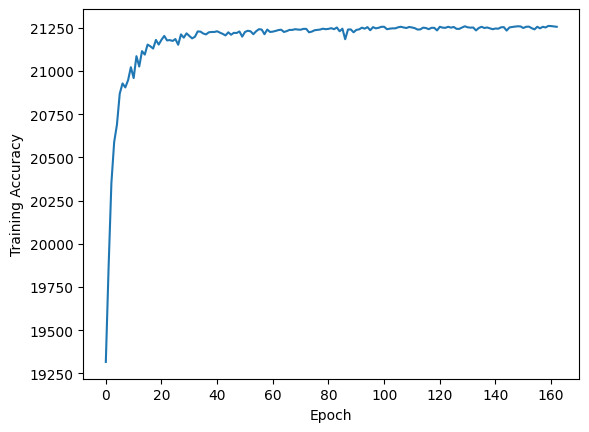

In [9]:
import matplotlib.pyplot as plt
plt.plot(model.accuracy_curve_)
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.show()

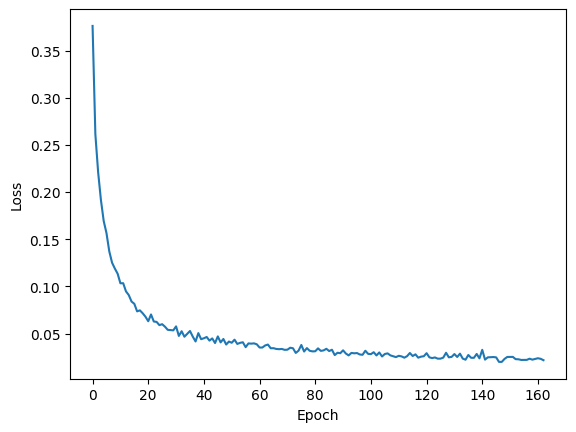

In [10]:
plt.plot(model.loss_curve_)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


# test accuracy:

In [50]:
print(classification_report(y_test, model.predict(X_test)))
disp = ConfusionMatrixDisplay.from_estimator(
        model,
        X_test,
        y_test,
        display_labels=['Healthy', 'MDD'],
        cmap=plt.cm.Blues,
        normalize='true',
        colorbar = False
    )
disp.confusion_matrix
plt.title('Confusion Matrix of MLP Classification')
plt.xlabel('Predicted Diagnosis')
plt.ylabel('True Diagnosis')
plt.show()

              precision    recall  f1-score   support

         0.0       0.50      0.90      0.64      7915
         1.0       0.50      0.10      0.17      7915

    accuracy                           0.50     15830
   macro avg       0.50      0.50      0.41     15830
weighted avg       0.50      0.50      0.41     15830



ValueError: ConfusionMatrixDisplay.from_estimator only supports classifiers

_Can try now with removing the diagonal from the matrices and retraining model. Then reconstructing matrices_

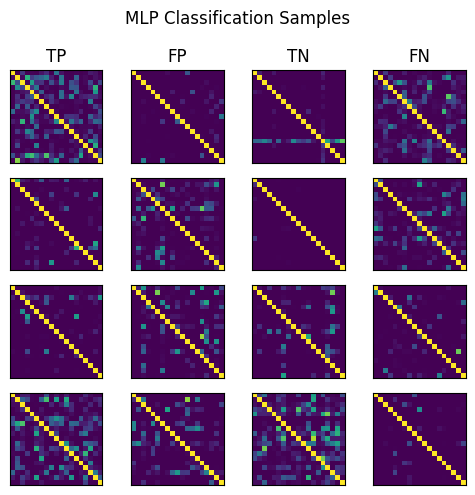

In [ ]:
# misclassification analysis
test_pred = model.predict(X_test)
TP = np.where((y_test == test_pred) & (test_pred ==1))[0]
TN = np.where((y_test == test_pred) & (test_pred == 0))[0]
FP = np.where((y_test != test_pred) & (test_pred == 1))[0]
FN = np.where((y_test != test_pred) & (test_pred == 0))[0]

TP_GC = X_test[np.random.choice(TP, 4)].reshape(4,19,19)
TN_GC = X_test[np.random.choice(TN, 4)].reshape(4,19,19)
FP_GC = X_test[np.random.choice(FP, 4)].reshape(4,19,19)
FN_GC = X_test[np.random.choice(FN, 4)].reshape(4,19,19)

fig, axs = plt.subplots(4, 4, figsize=(5,5))

for i, tp in enumerate(TP_GC):
    ax = axs[i][0]
    if i == 0:
        ax.set_title('TP')
    ax.imshow(tp)
    ax.set_xticks(())
    ax.set_yticks(())

for i, fp in enumerate(FP_GC): 
    ax = axs[i][1]
    if i == 0:
        ax.set_title('FP')
    ax.imshow(fp)
    ax.set_xticks(())
    ax.set_yticks(())

for i, tn in enumerate(TN_GC):
    ax = axs[i][2]
    if i == 0:
        ax.set_title('TN')
    ax.imshow(tn)
    ax.set_xticks(())
    ax.set_yticks(())
    
for i, fn in enumerate(FN_GC):
    ax = axs[i][3]
    if i == 0:
        ax.set_title('FN')
    ax.imshow(fn)
    ax.set_xticks(())
    ax.set_yticks(())

plt.suptitle('MLP Classification Samples')
plt.tight_layout()
plt.show()